For each weekday from Jan 8th, 2023, to January 22, 2022 (inclusive, 2 weeks worth, 10 days), collect all historical close prices for all Canadian Government Bonds which have a maturity less than 10 years from January 8, 2024 on the “Frankfurt” Exchange; I.e., all bonds listed via the following two links:
1. https://markets.businessinsider.com/bonds/finder?borrower=71&maturity=shortterm&yield=&bondtype=2%2c3%2c4%2c16&coupon=&currency=184&rating=&country=19
2. https://markets.businessinsider.com/bonds/finder?borrower=71&maturity=midterm&yield=&bondtype=2%2c3%2c4%2c16&coupon=&currency=184&rating=&country=19


In [3]:
import requests
from bs4 import BeautifulSoup

import re
import random
from urllib.parse import urlencode

import numpy as np
import pandas as pd
import json

from tqdm import tqdm

import scipy
from scipy import optimize

import matplotlib.pyplot as plt

### 1.1 Retrive bond links

In [ ]:
url1 = "https://markets.businessinsider.com/bonds/finder?borrower=71&maturity=shortterm&yield=&bondtype=2%2c3%2c4%2c16&coupon=&currency=184&rating=&country=19"
url2 = "https://markets.businessinsider.com/bonds/finder?borrower=71&maturity=midterm&yield=&bondtype=2%2c3%2c4%2c16&coupon=&currency=184&rating=&country=19"

In [ ]:
def get_bond_links(url:str) -> list:
  """
  get links of bonds listed at the website
  """
  list_of_links = []
  html_data = requests.get(url).text
  soup = BeautifulSoup(html_data, 'html.parser')
  # look for all links that refer to different bonds in the table
  for row in soup.find_all('tbody')[0].find_all('tr'):
    full_link = "https://markets.businessinsider.com" + row.find('a', href=True)['href']
    list_of_links.append(full_link)

  print(f"There are totally %d links found in this page." % (len(list_of_links)))
  return list_of_links

In [ ]:
links1 = get_bond_links(url1)

There are totally 20 links found in this page.


In [ ]:
links2 = get_bond_links(url2)

There are totally 19 links found in this page.


In [ ]:
links = links1 + links2

### 1.2 Retrieve bond data

In [ ]:
# request headers
base_url = 'https://markets.businessinsider.com/Ajax/Chart_GetChartData?'

headers = {
'Accept': 'application/json, text/plain, */*'
,'Accept-Encoding': 'gzip, deflate, br'
,'Accept-Language': 'en-CA,en;q=0.9,zh;q=0.8,en-GB;q=0.7,zh-CN;q=0.6'
,'Connection': 'keep-alive'
,'Host': 'markets.businessinsider.com'
,'Referer': 'https://markets.businessinsider.com/bonds/canadacd-bonds_201324-bond-2024-ca135087b451?miRedirects=1'
,'Sec-Fetch-Dest': 'empty'
,'Sec-Fetch-Mode': 'cors'
,'Sec-Fetch-Site': 'same-origin'
,'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36'
,'sec-ch-ua': '"Google Chrome";v="107", "Chromium";v="107", "Not=A?Brand";v="24"'
,'sec-ch-ua-mobile': '?0'
,'sec-ch-ua-platform': "macOS"
}

In [ ]:
def get_bond_data(tkData_code: str, from_date: str = '20231222', to_date :str = '20240122' ,
                  base_url: str = base_url, headers: dict = headers) -> str:
  """
  get the bond data from a web
  example:
  tkData_code: tkData_code
  'from': '20231110',
  'to': '20240110'
  """
  data = {
      'instrumentType': 'Bond',
      'tkData': tkData_code,
      'from': from_date,
      'to': to_date
      }
  url = base_url + urlencode(data)
  # print(url)
  try:
      response = requests.request("GET", url, headers = headers)
      #print(response)
      if response.status_code == 200:
          re = response.content.decode('gbk')
          table = make_df_from_str(re)
          return table
  except (TimeoutError, Exception):
      print('request failed.')

In [ ]:
def make_df_from_str (response: str) -> pd.DataFrame:
  """
  convert str into a dataframe
  """
  response_list = response[2:-2].split("},{")
  df = pd.DataFrame()
  for i in range(len(response_list)):
    df_temp = pd.DataFrame(json.loads("{" + response_list[i] + "}"), index=[0])
    df = pd.concat([df, df_temp], ignore_index = True)
  return df

In [ ]:
def get_bond_information(url: str) -> pd.DataFrame:
  """
  get the bond information from a web
  """
  basic_info = pd.read_html(url)[0].rename(columns = {0:'feature', 1:"value"})

  html_data = requests.get(url).text
  soup = BeautifulSoup(html_data, 'html.parser')
  data = soup.find_all('script')[26].string
  TKData = re.findall(r'"TKData" : "([0-9,]*)",', data)[0]
  basic_info.loc[len(basic_info)] = {'feature': 'TKData', 'value': TKData}
  return basic_info

In [ ]:
# whole bond information and pricing data
bond_dict = {}
from tqdm import tqdm

for i in tqdm(range(len(links))):
  link = links[i]
  bond_dict[link] = {}
  bond_dict[link]['info'] = get_bond_information(link)
  bond_dict[link]['data'] = get_bond_data(tkData_code = bond_dict[link]['info'].iloc[22,1])

In [ ]:
bond_dict[links1[0]]

### 1.3 Bond data for the project

In [2]:
daterange_only_date = ['2024-01-08', '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12',
    '2024-01-15', '2024-01-16', '2024-01-17', '2024-01-18', '2024-01-19']
daterange = [date + " 00:00" for date in daterange_only_date]
daterange_convert = {'2024-01-08 00:00': '0108', '2024-01-09 00:00': '0109',
                     '2024-01-10 00:00': '0110', '2024-01-11 00:00': '0111',
                     '2024-01-12 00:00': '0112', '2024-01-15 00:00': '0115',
                     '2024-01-16 00:00': '0116', '2024-01-17 00:00': '0117',
                     '2024-01-18 00:00': '0118', '2024-01-19 00:00': '0119'}

In [ ]:
def organize_data_table (links = links1, the_bond_dict = bond_dict, daterange: list = daterange) -> pd.DataFrame:
  """
  get only a few attributes and closing prices at some period
  """
  df = pd.DataFrame()
  global daterange_convert

  for link in links:
    #print(link)
    info = the_bond_dict[link]['info']
    data = the_bond_dict[link]['data']
    info_of_need  = info.iloc[[0, 7, 8, 10, 15]].T
    data_of_range = data[data['Date'].isin(daterange)][['Date', 'Close']].T

    row_a = info_of_need.rename(columns = info_of_need.iloc[0]).drop(info_of_need.index[0]).reset_index(drop = True)
    row_b = data_of_range.rename(columns = data_of_range.iloc[0]).drop(data_of_range.index[0]).reset_index(drop = True)

    df_temp = pd.concat([row_a, row_b], axis = 1)
    #print(df_temp)
    df = pd.concat([df, df_temp], ignore_index=True, sort = False)

  df_rename = df.rename(columns = daterange_convert)
  df_rename['bond_code'] = "CAN " + df_rename["Coupon"] + " " + df_rename['Maturity Date']
  return df_rename

In [ ]:
table = organize_data_table(links, bond_dict, daterange)
table

,ISIN,Issue Price,Issue Date,Coupon,Maturity Date,0108,0109,0110,0111,0112,0115,0116,0117,0118,0119,bond_code
0,CA135087L518,99.03,10/9/2020,0.250%,3/1/2026,92.862,92.86,92.844,92.856,93.023,93.008,92.796,92.57,92.546,92.545,CAN 0.250% 3/1/2026
1,CA135087N340,99.74,1/24/2022,1.500%,4/1/2025,96.533,96.545,96.591,96.64,96.72,96.68,96.62,96.5,96.49,96.48,CAN 1.500% 4/1/2025
2,CA135087P246,99.33,7/25/2022,3.000%,10/1/2025,98.19,98.2,98.26,98.25,98.31,98.31,98.21,98.02,97.98,97.97,CAN 3.000% 10/1/2025
3,CA135087K940,99.63,4/3/2020,0.500%,9/1/2025,94.34,94.37,94.38,94.43,94.49,94.49,94.42,94.25,94.24,94.22,CAN 0.500% 9/1/2025
4,CA135087D507,98.85,6/30/2014,2.250%,6/1/2025,97.399,97.399,97.42,97.362,97.495,97.485,97.324,97.173,97.147,97.16,CAN 2.250% 6/1/2025
5,CA135087J546,98.99,10/5/2018,2.250%,3/1/2024,99.63,99.64,99.65,99.661,99.67,99.687,99.68,99.683,99.708,99.72,CAN 2.250% 3/1/2024
6,CA135087VH40,98.21,8/2/1994,9.000%,6/1/2025,106.33,106.31,106.38,106.32,106.32,106.29,106.25,106.06,106.0,105.93,CAN 9.000% 6/1/2025
7,CA135087M508,99.97,7/12/2021,0.750%,10/1/2024,97.22,97.22,97.234,97.255,97.308,97.348,97.258,97.225,97.249,97.256,CAN 0.750% 10/1/2024
8,CA135087Q319,99.74,2/10/2023,3.750%,5/1/2025,99.19,99.23,99.24,99.25,99.28,99.27,99.24,99.08,99.06,99.01,CAN 3.750% 5/1/2025
9,CA135087P816,99.47,1/20/2023,3.000%,4/1/2026,98.27,98.28,98.37,98.35,98.43,98.44,98.3,98.05,98.0,97.99,CAN 3.000% 4/1/2026


In [ ]:
# to be selected manually
table.to_excel("bond_lists.xlsx")

### 2.1 ytm curve

In [25]:
daterange_only_date = ['2024-01-08', '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12',
    '2024-01-15', '2024-01-16', '2024-01-17', '2024-01-18', '2024-01-19']
daterange = [date + " 00:00" for date in daterange_only_date]
daterange_convert = {'2024-01-08 00:00': '0108', '2024-01-09 00:00': '0109',
                     '2024-01-10 00:00': '0110', '2024-01-11 00:00': '0111',
                     '2024-01-12 00:00': '0112', '2024-01-15 00:00': '0115',
                     '2024-01-16 00:00': '0116', '2024-01-17 00:00': '0117',
                     '2024-01-18 00:00': '0118', '2024-01-19 00:00': '0119'}

In [26]:
bonds = pd.read_excel("/content/selected_bonds.xlsx")

In [27]:
bonds['Maturity Date'] = pd.to_datetime(bonds['Maturity Date'])

In [28]:
bonds

,ISIN,Issue Price,Issue Date,Coupon,Maturity Date,0108,0109,0110,0111,0112,0115,0116,0117,0118,0119,bond_code
0,CA135087N910,99.99,5/24/2022,2.750%,2024-08-01,98.818,98.822,98.835,98.841,98.878,98.909,98.839,98.832,98.856,98.860,CAN 2.75 Aug 24
1,CA135087K528,99.62,10/11/2019,1.250%,2025-03-01,96.460,96.482,96.552,96.576,96.661,96.715,96.540,96.448,96.495,96.460,CAN 1.25 Mar 25
2,CA135087Q640,99.66,5/12/2023,3.500%,2025-08-01,98.998,98.997,99.021,99.007,99.111,99.094,98.970,98.790,98.760,98.720,CAN 3.50 Aug 25
3,CA135087P816,99.47,1/20/2023,3.000%,2026-04-01,98.270,98.280,98.370,98.350,98.430,98.440,98.300,98.050,98.000,97.990,CAN 3.00 Apr 26
4,CA135087L930,99.66,4/16/2021,1.000%,2026-09-01,93.460,93.440,93.550,93.530,93.600,93.570,93.400,93.120,93.080,93.070,CAN 1.00 Sep 26
5,CA135087M847,99.66,10/15/2021,1.250%,2027-03-01,93.282,93.301,93.245,93.186,93.467,93.493,93.141,92.856,92.753,92.764,CAN 1.25 Mar 27
6,CA135087N837,99.30,5/13/2022,2.750%,2027-09-01,97.580,97.591,97.603,97.520,97.740,97.772,97.441,97.092,96.956,96.947,CAN 2.75 Sep 27
7,CA135087P576,99.35,10/21/2022,3.500%,2028-03-01,100.500,100.480,100.439,100.328,100.637,100.673,100.220,99.834,99.662,99.623,CAN 3.50 Mar 28
8,CA135087Q491,100.00,4/21/2023,3.250%,2028-09-01,99.740,99.720,99.720,99.550,99.880,99.910,99.440,98.990,98.810,98.770,CAN 3.25 Sept 28
9,CA135087Q988,99.42,10/13/2023,4.000%,2029-03-01,103.406,103.380,103.279,103.132,103.542,103.552,102.974,102.483,102.279,102.242,CAN 4.00 Mar 29


In [34]:
class Bond:

  def __init__(self, data: pd.Series):
    self.coupon_rate     = float(data['Coupon'][:-1])/100
    self.maturity_date   = data['Maturity Date']
    self.bond_price_list = data[5:15].astype('float').tolist()
    self.current_date = pd.Timestamp(2024, 1, 1)

    self.period = self.count_period()
    self.ytms   = []
    self.dirty  = []

  # information
  def count_period(self):
    current_date = self.current_date
    delta = self.maturity_date - current_date
    # half year = 1 period
    period = int(delta.days / 182)
    # print("period", period)
    return period

  def calculate_accrued_interest(self):
    current_date = self.current_date
    delta = self.maturity_date - current_date
    # half year = 1 period
    period = int(delta.days / 182)
    days_since_last_payment = (period + 1) * 182 - delta.days
    # print("aci", (days_since_last_payment / 365) * self.coupon_rate * 100)
    return (days_since_last_payment / 365) * self.coupon_rate * 100

  # coupon + face valu
  def get_face_value_pv (self, interest, face_value = 100, freqency = 2):
    return face_value / (1 + interest / freqency) ** self.period

  def get_coupon_pv (self, interest, period, freqency = 2):
    coupon = self.coupon_rate * 100 / 2
    pv = coupon / (1 + interest / freqency) ** period
    return pv

  def get_coupon_pv_total (self, interest, freqency = 2):
    pv_total = 0
    for period_slot in range (self.period):
      pv_total += self.get_coupon_pv(interest, period_slot+1, freqency)
    # print("pv_total", pv_total)
    return pv_total

  # equation two sides
  def calculated_price(self, interest):
    return self.get_face_value_pv(interest) + self.get_coupon_pv_total(interest)

  def dirty_price(self, clean_price):
    return clean_price + self.calculate_accrued_interest()

  # only used in spot curve
  def get_dirty_price(self):
    for bond_price in self.bond_price_list:
      self.dirty.append(self.dirty_price(bond_price))
    return self.dirty

  # ytms
  def get_ytm (self, clean_price, estimate = 0.05):
    get_yield = lambda interest: self.calculated_price(interest) - self.dirty_price(clean_price)
    # print("dirty", self.dirty_price(clean_price))
    return optimize.newton(get_yield, estimate)

  def get_ytms(self):
    for bond_price in self.bond_price_list:
      self.ytms.append(self.get_ytm(bond_price))
    return self.ytms

In [35]:
ytm_table = pd.DataFrame()
for bond_row in range(len(bonds)):
  bond = Bond(bonds.iloc[bond_row])
  ytms = bond.get_ytms()

  df_temp = pd.DataFrame(ytms)
  ytm_table = pd.concat([ytm_table, df_temp], axis = 1, ignore_index = True)

In [36]:
ytm_table_by_day = ytm_table.T
ytm_table_by_day.columns = daterange_only_date
ytm_table_by_day

,2024-01-08,2024-01-09,2024-01-10,2024-01-11,2024-01-12,2024-01-15,2024-01-16,2024-01-17,2024-01-18,2024-01-19
0,0.028399,0.028318,0.028054,0.027933,0.027182,0.026554,0.027973,0.028115,0.027628,0.027547
1,0.044810,0.044578,0.043837,0.043583,0.042686,0.042116,0.043964,0.044938,0.044440,0.044810
2,0.031997,0.032004,0.031840,0.031936,0.031223,0.031339,0.032190,0.033426,0.033633,0.033908
3,0.035214,0.035162,0.034689,0.034794,0.034374,0.034322,0.035057,0.036372,0.036636,0.036688
4,0.036235,0.036322,0.035840,0.035928,0.035621,0.035752,0.036498,0.037730,0.037906,0.037950
5,0.034836,0.034766,0.034972,0.035189,0.034156,0.034060,0.035355,0.036407,0.036788,0.036748
6,0.032183,0.032149,0.032113,0.032368,0.031692,0.031594,0.032610,0.033687,0.034107,0.034135
7,0.030661,0.030714,0.030822,0.031117,0.030298,0.030202,0.031404,0.032433,0.032892,0.032997
8,0.030669,0.030717,0.030717,0.031123,0.030336,0.030264,0.031386,0.032466,0.032900,0.032996
9,0.029860,0.029915,0.030129,0.030440,0.029573,0.029552,0.030775,0.031819,0.032255,0.032334


Text(0, 0.5, 'Ytm')

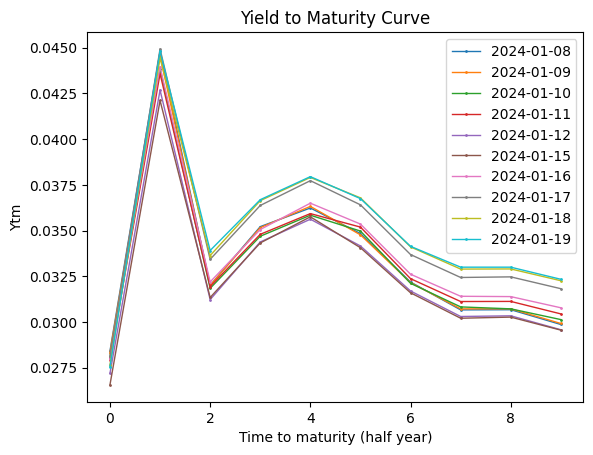

In [37]:
ax = ytm_table_by_day.plot.line(lw = 1, marker='.', markersize = 2, title='Yield to Maturity Curve')
ax.set_xlabel("Time to maturity (half year)")
ax.set_ylabel("Ytm")

### 2.2 Spot curves

In [38]:
# change clean price to dirty price
bond_dirty_price = bonds.copy()
for bond_row in range(len(bond_dirty_price)):
  bond = Bond(bond_dirty_price.iloc[bond_row])
  dirty_prices = bond.get_dirty_price()
  bond_dirty_price.iloc[bond_row, 5:15] = dirty_prices

bond_dirty_price

,ISIN,Issue Price,Issue Date,Coupon,Maturity Date,0108,0109,0110,0111,0112,0115,0116,0117,0118,0119,bond_code
0,CA135087N910,99.99,5/24/2022,2.750%,2024-08-01,99.955671,99.959671,99.972671,99.978671,100.015671,100.046671,99.976671,99.969671,99.993671,99.997671,CAN 2.75 Aug 24
1,CA135087K528,99.62,10/11/2019,1.250%,2025-03-01,96.874384,96.896384,96.966384,96.990384,97.075384,97.129384,96.954384,96.862384,96.909384,96.874384,CAN 1.25 Mar 25
2,CA135087Q640,99.66,5/12/2023,3.500%,2025-08-01,100.436356,100.435356,100.459356,100.445356,100.549356,100.532356,100.408356,100.228356,100.198356,100.158356,CAN 3.50 Aug 25
3,CA135087P816,99.47,1/20/2023,3.000%,2026-04-01,99.001507,99.011507,99.101507,99.081507,99.161507,99.171507,99.031507,98.781507,98.731507,98.721507,CAN 3.00 Apr 26
4,CA135087L930,99.66,4/16/2021,1.000%,2026-09-01,93.783288,93.763288,93.873288,93.853288,93.923288,93.893288,93.723288,93.443288,93.403288,93.393288,CAN 1.00 Sep 26
5,CA135087M847,99.66,10/15/2021,1.250%,2027-03-01,93.689534,93.708534,93.652534,93.593534,93.874534,93.900534,93.548534,93.263534,93.160534,93.171534,CAN 1.25 Mar 27
6,CA135087N837,99.30,5/13/2022,2.750%,2027-09-01,98.461507,98.472507,98.484507,98.401507,98.621507,98.653507,98.322507,97.973507,97.837507,97.828507,CAN 2.75 Sep 27
7,CA135087P576,99.35,10/21/2022,3.500%,2028-03-01,101.621918,101.601918,101.560918,101.449918,101.758918,101.794918,101.341918,100.955918,100.783918,100.744918,CAN 3.50 Mar 28
8,CA135087Q491,100.00,4/21/2023,3.250%,2028-09-01,100.763973,100.743973,100.743973,100.573973,100.903973,100.933973,100.463973,100.013973,99.833973,99.793973,CAN 3.25 Sept 28
9,CA135087Q988,99.42,10/13/2023,4.000%,2029-03-01,104.677233,104.651233,104.550233,104.403233,104.813233,104.823233,104.245233,103.754233,103.550233,103.513233,CAN 4.00 Mar 29


In [39]:
def bootstrap_yield_curve(bonds):
  spot_rates = np.zeros(len(bonds))

  for i, pair in enumerate(bonds):
    coupon_rate = pair[0]
    price = pair[1]
    # i+1 is period cnt: 1, 2, 3, ...
    coupon_semi_year = coupon_rate / 2
    cash_flows = np.array([coupon_semi_year] * (i)) # + [100 + coupon_rate/2])
    #print("cash_flows", cash_flows)

    # half-year as one period
    time_periods = np.arange(1, i + 1)
    #print("time_periods", time_periods)

    # Use previously calculated spot rates for discounted cash flows
    if i == 0:
      discounted_cash_flows = 0
      #print("discounted_cash_flows", discounted_cash_flows)
    else:
      discounted_cash_flows = [cf / (1 + spot_rates[j]/ 2) ** time_periods[j] for j, cf in enumerate(cash_flows)]
      discounted_cash_flows = np.sum(discounted_cash_flows)
      #print("discounted_cash_flows", discounted_cash_flows)

    residual = price - discounted_cash_flows
    #print("residual", residual)
    if residual <= 0:
      # Handle cases where residual is too low
      #print(f"Warning: Residual for bond with maturity {i} is too low. Adjusting spot rate calculation.")
      spot_rate = spot_rates[i-1] / 2  # Use previous spot rate as an approximation
      #print("spot_rate", spot_rate)
    else:
      payment_at_last = 100 + coupon_semi_year
      #print(payment_at_last)
      spot_rate = (payment_at_last / residual)**(1 / (i + 1)) - 1
      #print("spot_rate", spot_rate)
    spot_rates[i] = spot_rate * 2
    #print( spot_rate * 2)

  return spot_rates

In [40]:
def bond_list_generation():
  input_list = []
  for i in range(10):
    temp = bond_dirty_price.iloc[:,[3, (5 + i)]].values.tolist()
    temp = [[float(a[:-1]) , b]for [a, b] in temp]
    input_list.append(temp)
  return input_list

bond_inputs = bond_list_generation()

In [41]:
yield_curve_table = pd.DataFrame()

for bond_input in bond_inputs:
  spot_rates = bootstrap_yield_curve(bond_input)
  temp = pd.DataFrame(spot_rates)
  yield_curve_table = pd.concat([yield_curve_table, temp], axis = 1)

In [42]:
yield_curve_table_by_day = yield_curve_table
yield_curve_table_by_day.columns = daterange_only_date
yield_curve_table_by_day

,2024-01-08,2024-01-09,2024-01-10,2024-01-11,2024-01-12,2024-01-15,2024-01-16,2024-01-17,2024-01-18,2024-01-19
0,0.028399,0.028318,0.028054,0.027933,0.027182,0.026554,0.027973,0.028115,0.027628,0.027547
1,0.044863,0.044630,0.043888,0.043634,0.042735,0.042166,0.044015,0.044991,0.044494,0.044866
2,0.031870,0.031880,0.031723,0.031824,0.031114,0.031242,0.032078,0.033324,0.033543,0.033819
3,0.035205,0.035154,0.034679,0.034787,0.034376,0.034327,0.035050,0.036373,0.036646,0.036694
4,0.036243,0.036332,0.035849,0.035937,0.035634,0.035769,0.036511,0.037744,0.037922,0.037965
5,0.034822,0.034751,0.034967,0.035187,0.034146,0.034050,0.035350,0.036401,0.036787,0.036743
6,0.032045,0.032011,0.031983,0.032245,0.031570,0.031471,0.032485,0.033559,0.033991,0.034017
7,0.030412,0.030470,0.030598,0.030903,0.030075,0.029979,0.031190,0.032213,0.032687,0.032794
8,0.030465,0.030517,0.030525,0.030947,0.030155,0.030084,0.031208,0.032287,0.032731,0.032829
9,0.029561,0.029621,0.029863,0.030183,0.029304,0.029288,0.030522,0.031562,0.032008,0.032087


Text(0, 0.5, 'Yield')

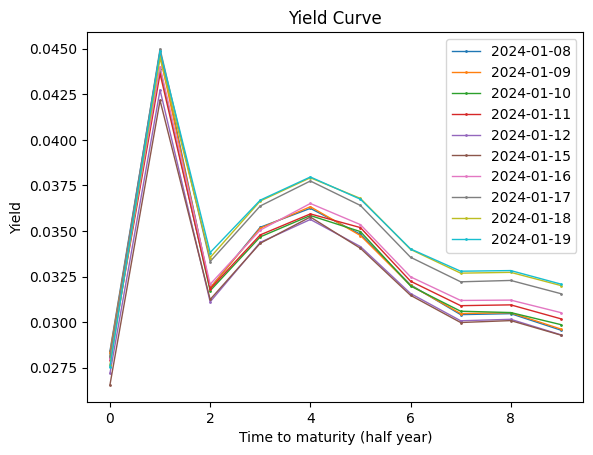

In [43]:
ax = yield_curve_table_by_day.plot.line(lw = 1, marker='.', markersize = 2, title='Yield Curve')
ax.set_xlabel("Time to maturity (half year)")
ax.set_ylabel("Yield")

In [48]:
# difference
yield_curve_table_by_day - ytm_table_by_day

,2024-01-08,2024-01-09,2024-01-10,2024-01-11,2024-01-12,2024-01-15,2024-01-16,2024-01-17,2024-01-18,2024-01-19
0,1.873501e-16,1.422473e-16,5.134781e-16,3.538836e-16,4.544976e-16,5.308254e-16,3.469447e-16,6.591949e-16,4.093947e-16,6.314393e-16
1,5.253242e-05,5.203700e-05,5.048129e-05,5.004973e-05,4.955281e-05,4.972726e-05,5.115506e-05,5.386270e-05,5.381505e-05,5.528282e-05
2,-1.271186e-04,-1.238503e-04,-1.166504e-04,-1.113544e-04,-1.089817e-04,-9.670776e-05,-1.115609e-04,-1.021097e-04,-8.991360e-05,-8.890236e-05
3,-8.847531e-06,-8.081944e-06,-1.043793e-05,-6.799715e-06,1.408747e-06,5.514531e-06,-6.730554e-06,1.216526e-06,1.044157e-05,6.012423e-06
4,8.141083e-06,9.799187e-06,9.054940e-06,9.862391e-06,1.325076e-05,1.626626e-05,1.306960e-05,1.437512e-05,1.597539e-05,1.468513e-05
5,-1.404521e-05,-1.484980e-05,-4.512780e-06,-1.570836e-06,-9.739704e-06,-1.023948e-05,-4.748942e-06,-6.300486e-06,-1.305340e-06,-4.035447e-06
6,-1.385382e-04,-1.385204e-04,-1.293915e-04,-1.223374e-04,-1.224581e-04,-1.234924e-04,-1.250717e-04,-1.271405e-04,-1.161869e-04,-1.184089e-04
7,-2.486934e-04,-2.432956e-04,-2.241856e-04,-2.139814e-04,-2.228993e-04,-2.238459e-04,-2.143157e-04,-2.197488e-04,-2.052607e-04,-2.029575e-04
8,-2.045012e-04,-2.004057e-04,-1.918671e-04,-1.760834e-04,-1.812631e-04,-1.804565e-04,-1.779693e-04,-1.791289e-04,-1.689572e-04,-1.675927e-04
9,-2.996864e-04,-2.945480e-04,-2.656289e-04,-2.570915e-04,-2.698272e-04,-2.643140e-04,-2.526308e-04,-2.573968e-04,-2.461149e-04,-2.462341e-04


### 2.3 forward rate


In [49]:
def get_forward_rate(yield_curve_table_by_day):
  out = pd.DataFrame()
  for day in range(10):
    spot_rates = yield_curve_table_by_day.iloc[:, day].tolist()
    temp = []
    for i in range (4):
      # using semi-annually compounding
      real_n_interval = 2*(i+1) # 2, 4, 6, 8
      spot1 = spot_rates[real_n_interval + 1] # 3, 5, 7, 9 -> 4, 6, 8, 10
      spot2 = spot_rates[1]                   # 1 -> 2
      F = ((1+spot1)**(2*real_n_interval + 2) / (1+spot2)**(4))**(1/real_n_interval) - 1
      temp.append(F)
    out = pd.concat([out, pd.DataFrame(temp)], axis = 1)
  return out

In [50]:
forward_table = get_forward_rate(yield_curve_table_by_day)
forward_table.columns = daterange_only_date
forward_table.index = ["1yr-1yr", "1yr-2yr","1yr-3yr", "1yr-4yr"]
forward_table

,2024-01-08,2024-01-09,2024-01-10,2024-01-11,2024-01-12,2024-01-15,2024-01-16,2024-01-17,2024-01-18,2024-01-19
1yr-1yr,0.016157,0.016458,0.016503,0.017319,0.017857,0.018826,0.017349,0.019349,0.021127,0.020543
1yr-2yr,0.042568,0.042623,0.043909,0.044719,0.042991,0.043319,0.044747,0.046421,0.047895,0.047413
1yr-3yr,0.041483,0.041776,0.042572,0.043461,0.042104,0.042256,0.043883,0.045650,0.047104,0.047108
1yr-4yr,0.044569,0.044823,0.045748,0.046605,0.045047,0.045297,0.047190,0.049078,0.050351,0.050345


Text(0, 0.5, 'Forward rate')

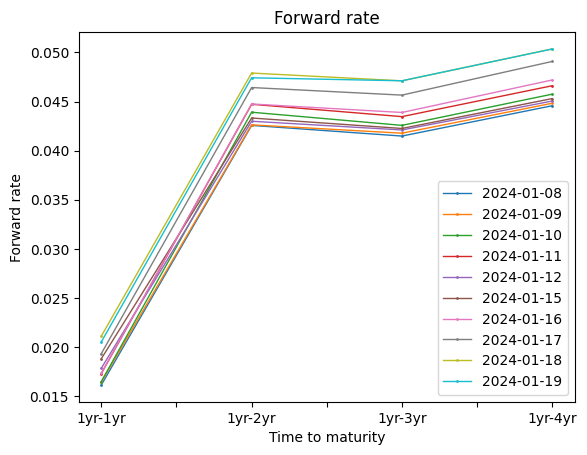

In [51]:
ax = forward_table.plot.line(lw = 1, marker='.', markersize = 2, title='Forward rate')
ax.set_xlabel("Time to maturity")
ax.set_ylabel("Forward rate")

### 3.1 Covariance matrix: daily log return, forward rates

In [52]:
def calculate_covariance(df):
  array = np.array(df)
  t1 = array[:,:9]
  t2 = array[:,1:]
  log_diff = np.log(t2/t1)
  #print(log_diff)
  return np.cov(log_diff)

In [62]:
np.set_printoptions(suppress=False)

In [64]:
# question 5(1): log-returns of yield cov matrix
calculate_covariance(ytm_table_by_day)

array([[0.00054357, 0.00044925, 0.00027645, 0.0002227 , 0.00019615,
        0.00036156, 0.00030236, 0.00036346, 0.0003456 , 0.00037368],
       [0.00044925, 0.00043397, 0.0003078 , 0.00026726, 0.00023715,
        0.00033152, 0.00029986, 0.0003406 , 0.0003327 , 0.0003453 ],
       [0.00027645, 0.0003078 , 0.00030356, 0.00026187, 0.00022854,
        0.00030816, 0.0002837 , 0.00031254, 0.00031178, 0.00032226],
       [0.0002227 , 0.00026726, 0.00026187, 0.00025215, 0.00022095,
        0.00025104, 0.00024886, 0.00026153, 0.00026702, 0.00026383],
       [0.00019615, 0.00023715, 0.00022854, 0.00022095, 0.00019883,
        0.00021155, 0.0002111 , 0.00022052, 0.00022632, 0.0002226 ],
       [0.00036156, 0.00033152, 0.00030816, 0.00025104, 0.00021155,
        0.00037711, 0.00032417, 0.00037343, 0.0003624 , 0.00039013],
       [0.00030236, 0.00029986, 0.0002837 , 0.00024886, 0.0002111 ,
        0.00032417, 0.00029318, 0.00032753, 0.0003237 , 0.00033738],
       [0.00036346, 0.0003406 , 0.0003125

In [54]:
# question 5(2): forward rates cov matrix
calculate_covariance(forward_table)

array([[3.38640973e-03, 2.11912417e-04, 1.22430869e-04, 3.08282694e-05],
       [2.11912417e-04, 6.27443068e-04, 5.44478070e-04, 5.55862611e-04],
       [1.22430869e-04, 5.44478070e-04, 5.02881841e-04, 5.10500935e-04],
       [3.08282694e-05, 5.55862611e-04, 5.10500935e-04, 5.25320661e-04]])

### 3.2 Evalues and Evectors

In [65]:
# yield
EValue1, EVector1 = np.linalg.eig(calculate_covariance(ytm_table_by_day))

In [66]:
# question 6(1): log-returns of yield eigenvalues
EValue1

array([ 3.12239229e-03,  2.56046791e-04,  1.39533031e-04,  1.62424353e-05,
        5.56673432e-06,  3.02912356e-06,  5.12776080e-07,  4.51062051e-07,
        3.27635420e-20, -1.91787297e-20])

In [76]:
# question 6(1): log-returns of yield eigenvectors
EVector1.round(5)

array([[-3.5633e-01, -7.5355e-01,  1.7870e-02, -2.5686e-01,  2.9545e-01,
        -1.5380e-01,  2.9557e-01, -1.6046e-01, -2.5940e-02,  1.2019e-01],
       [-3.4278e-01, -3.5783e-01,  4.7173e-01,  3.5495e-01, -4.2230e-01,
         2.1177e-01, -3.2507e-01,  2.3242e-01,  5.2730e-02, -1.5184e-01],
       [-2.9579e-01,  2.6313e-01,  1.8380e-01,  6.7641e-01,  1.7634e-01,
        -2.8939e-01,  3.4082e-01, -1.9205e-01, -3.5120e-02,  2.8032e-01],
       [-2.5347e-01,  3.1869e-01,  4.0665e-01, -3.5097e-01, -1.6188e-01,
         2.4374e-01,  5.1400e-01, -1.7515e-01, -1.3268e-01, -3.0749e-01],
       [-2.1851e-01,  2.6016e-01,  4.5697e-01, -2.8159e-01,  5.7288e-01,
        -1.2315e-01, -4.8811e-01,  8.6650e-02,  4.3430e-02,  5.2460e-02],
       [-3.3753e-01,  6.6140e-02, -3.6595e-01,  1.3595e-01,  3.0600e-01,
         4.7246e-01,  2.4780e-02,  3.9304e-01, -5.0612e-01,  1.5580e-01],
       [-3.0098e-01,  1.7001e-01, -9.1110e-02, -2.6164e-01, -2.5893e-01,
         3.0374e-01,  6.6320e-02,  9.3070e-02

In [81]:
# forward rates
EValue2, EVector2 = np.linalg.eig(calculate_covariance(forward_table))

In [82]:
# question 6(2): forward rates eigenvalues
EValue2

array([3.41657562e-03, 1.60334194e-03, 2.00976795e-05, 2.04006552e-06])

In [83]:
# question 6(2): forward rates eigenvectors
EVector2

array([[ 0.99222343,  0.11911471,  0.02845867,  0.02223654],
       [ 0.09661742, -0.60302644, -0.78859575, -0.07170026],
       [ 0.06692571, -0.54820284,  0.48880316, -0.67532663],
       [ 0.04097189, -0.56713706,  0.37199236,  0.73368832]])